<a href="https://colab.research.google.com/github/jinmedi/MT_project/blob/main/mp_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


내시경 이미지 부분만 크롭

In [ ]:
import cv2
import numpy as np
import os

def detect_and_crop_color_image(image_path, padding=10):
    # Read the image
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Unable to read image at {image_path}")
        return None

    # Convert to HSV color space
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # Define range for high saturation colors
    lower_sat = np.array([0, 50, 50])
    upper_sat = np.array([179, 255, 255])

    # Threshold the HSV image to get only high saturation colors
    mask = cv2.inRange(hsv, lower_sat, upper_sat)

    # Perform morphological operations to remove noise
    kernel = np.ones((5,5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

    # Find contours in the mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        print(f"Warning: No color regions found in {image_path}")
        return None

    # Find the largest contour (which should be our color image)
    largest_contour = max(contours, key=cv2.contourArea)

    # Get the bounding rectangle of the largest contour
    x, y, w, h = cv2.boundingRect(largest_contour)

    # Add padding
    x = max(0, x - padding)
    y = max(0, y - padding)
    w = min(img.shape[1] - x, w + 2*padding)
    h = min(img.shape[0] - y, h + 2*padding)

    # Crop the image
    cropped = img[y:y+h, x:x+w]

    return cropped

def crop_images_in_folder(input_folder, output_folder):
    # Create output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for filename in os.listdir(input_folder):
        img_path = os.path.join(input_folder, filename)
        if os.path.isfile(img_path):
            cropped_image = detect_and_crop_color_image(img_path)
            if cropped_image is not None:
                output_path = os.path.join(output_folder, filename)
                cv2.imwrite(output_path, cropped_image)
                print(f"Processed and saved: {filename}")
            else:
                print(f"Failed to process: {filename}")

# Example usage:
input_folder = '/content/drive/MyDrive/Colab Notebooks/MT_project/MT_0'
output_folder = '/content/drive/MyDrive/Colab Notebooks/MT_project/MT_0_crop'
crop_images_in_folder(input_folder, output_folder)

Processed and saved: c0_22_81bddd1d.jpg
Processed and saved: c0_2_0d1ebf6c.jpg
Processed and saved: c0_2_b9bd9ee4.jpg
Processed and saved: c0_25_81bddd1d.jpg
Processed and saved: c0_11_81bddd1d.jpg
Processed and saved: c0_2_c318f4f9.jpg
Processed and saved: c0_18_81bddd1d.jpg
Processed and saved: c0_2_487cae5b.jpg
Processed and saved: c0_16_81bddd1d.jpg
Processed and saved: c0_13_81bddd1d.jpg
Processed and saved: c0_17_81bddd1d.jpg
Processed and saved: c0_2_3644aa4c.jpg
Processed and saved: c0_32_81bddd1d.jpg
Processed and saved: c0_33_81bddd1d.jpg
Processed and saved: c0_2_7317a4b5.jpg
Processed and saved: c0_2_8bc95ee5.jpg
Processed and saved: c0_2_f7db44d2.jpg
Processed and saved: c0_27_81bddd1d.jpg
Processed and saved: c0_30_81bddd1d.jpg
Processed and saved: c0_31_81bddd1d.jpg


In [ ]:
import os
import numpy as np
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from collections import defaultdict

# 데이터 경로 설정
class_0_path = '/content/drive/MyDrive/Colab Notebooks/MT_project/MT_0_crop'
class_1_path = '/content/drive/MyDrive/Colab Notebooks/MT_project/MT_1_crop'

# 이미지 파일 경로와 레이블 불러오기
def load_images_and_labels_by_patient(class_0_path, class_1_path):
    images_by_patient = defaultdict(list)
    labels_by_patient = {}

    def process_directory(directory, label):
        for filename in os.listdir(directory):
            img_path = os.path.join(directory, filename)
            if img_path.endswith('.jpg') or img_path.endswith('.png'):
                image = img_to_array(load_img(img_path, target_size=(224, 224)))
                patient_hash = filename[-12:-4]  # 파일명의 마지막 8자리가 환자 해시값
                images_by_patient[patient_hash].append(image)
                labels_by_patient[patient_hash] = label

    process_directory(class_0_path, 0)
    process_directory(class_1_path, 1)

    return images_by_patient, labels_by_patient

# 데이터 불러오기
images_by_patient, labels_by_patient = load_images_and_labels_by_patient(class_0_path, class_1_path)

# 환자 해시값을 리스트로 변환
patient_hashes = list(images_by_patient.keys())
labels = [labels_by_patient[hash] for hash in patient_hashes]

# Stratified K-Fold 설정
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Stratified K-Fold 교차 검증 수행
fold = 1
for train_index, test_index in skf.split(patient_hashes, labels):
    train_hashes = [patient_hashes[i] for i in train_index]
    test_hashes = [patient_hashes[i] for i in test_index]

    X_train, y_train = [], []
    X_test, y_test = [], []

    for hash in train_hashes:
        X_train.extend(images_by_patient[hash])
        y_train.extend([labels_by_patient[hash]] * len(images_by_patient[hash]))

    for hash in test_hashes:
        X_test.extend(images_by_patient[hash])
        y_test.extend([labels_by_patient[hash]] * len(images_by_patient[hash]))

    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)

    print(f'Fold {fold}:')
    print(f'Train data shape: {X_train.shape}')
    print(f'Test data shape: {X_test.shape}')
    print(f'Train labels distribution: {np.bincount(y_train)}')
    print(f'Test labels distribution: {np.bincount(y_test)}')
    fold += 1

    # 모델 학습 및 평가를 위한 코드 추가 가능
    # 예: 모델 초기화, 학습, 평가 등


Fold 1:
Train data shape: (3573, 224, 224, 3)
Test data shape: (1052, 224, 224, 3)
Train labels distribution: [1604 1969]
Test labels distribution: [469 583]
Fold 2:
Train data shape: (3647, 224, 224, 3)
Test data shape: (978, 224, 224, 3)
Train labels distribution: [1637 2010]
Test labels distribution: [436 542]
Fold 3:
Train data shape: (3639, 224, 224, 3)
Test data shape: (986, 224, 224, 3)
Train labels distribution: [1631 2008]
Test labels distribution: [442 544]
Fold 4:
Train data shape: (3838, 224, 224, 3)
Test data shape: (787, 224, 224, 3)
Train labels distribution: [1684 2154]
Test labels distribution: [389 398]
Fold 5:
Train data shape: (3803, 224, 224, 3)
Test data shape: (822, 224, 224, 3)
Train labels distribution: [1736 2067]
Test labels distribution: [337 485]


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, GaussianNoise
from tensorflow.keras.optimizers import Adam

base_model = tf.keras.applications.EfficientNetB2(weights='imagenet', input_shape=(224, 224, 3), include_top=False)

for layer in base_model.layers:
    layer.trainable = False

model = Sequential()
model.add(base_model)
model.add(GaussianNoise(0.35))
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(GaussianNoise(0.35))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))
model.summary()


31790344/31790344 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb2 (Functional  (None, 7, 7, 1408)        7768569   
 )                                                               
                                                                 
 gaussian_noise (GaussianNo  (None, 7, 7, 1408)        0         
 ise)                                                            
                                                                 
 global_average_pooling2d (  (None, 1408)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               360704    
                                                                 
 batch_normalization (Batch  (None, 256)               10

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from sklearn.model_selection import StratifiedKFold
from collections import defaultdict

datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

datagen.fit(X_train)

# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 모델 학습
model.fit(datagen.flow(X_train, y_train, batch_size=32), epochs=10, validation_data=(X_test, y_test))


Epoch 1/10
119/119 [==============================] - 56s 352ms/step - loss: 0.8646 - accuracy: 0.6263 - val_loss: 0.6093 - val_accuracy: 0.6667
Epoch 2/10
119/119 [==============================] - 39s 328ms/step - loss: 0.7455 - accuracy: 0.6584 - val_loss: 0.5896 - val_accuracy: 0.6898
Epoch 3/10
119/119 [==============================] - 39s 330ms/step - loss: 0.6914 - accuracy: 0.6923 - val_loss: 0.5859 - val_accuracy: 0.7092
Epoch 4/10
119/119 [==============================] - 39s 329ms/step - loss: 0.6436 - accuracy: 0.7058 - val_loss: 0.6053 - val_accuracy: 0.7056
Epoch 5/10
119/119 [==============================] - 39s 330ms/step - loss: 0.6149 - accuracy: 0.7239 - val_loss: 0.5830 - val_accuracy: 0.7178
Epoch 6/10
119/119 [==============================] - 39s 331ms/step - loss: 0.5749 - accuracy: 0.7255 - val_loss: 0.6265 - val_accuracy: 0.7007
Epoch 7/10
119/119 [==============================] - 40s 333ms/step - loss: 0.5774 - accuracy: 0.7376 - val_loss: 0.5861 - val_ac

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Fold {fold} - Loss: {loss}, Accuracy: {accuracy}')
fold += 1

26/26 [==============================] - 1s 53ms/step - loss: 0.5878 - accuracy: 0.7165
Fold 6 - Loss: 0.5878094434738159, Accuracy: 0.7165449857711792


In [ ]:
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

fold = 1
for train_index, test_index in skf.split(patient_hashes, labels):
    train_hashes = [patient_hashes[i] for i in train_index]
    test_hashes = [patient_hashes[i] for i in test_index]

    X_train, y_train = [], []
    X_test, y_test = [], []

    for hash in train_hashes:
        X_train.extend(images_by_patient[hash])
        y_train.extend([labels_by_patient[hash]] * len(images_by_patient[hash]))

    for hash in test_hashes:
        X_test.extend(images_by_patient[hash])
        y_test.extend([labels_by_patient[hash]] * len(images_by_patient[hash]))

    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)

    # 데이터 증강 설정
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    datagen.fit(X_train)

    # 모델 컴파일
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # 모델 학습
    model.fit(datagen.flow(X_train, y_train, batch_size=32), epochs=10, validation_data=(X_test, y_test))

    # 모델 평가
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f'Fold {fold} - Loss: {loss}, Accuracy: {accuracy}')
    fold += 1


Epoch 1/10
112/112 [==============================] - 50s 363ms/step - loss: 0.5803 - accuracy: 0.7316 - val_loss: 0.4370 - val_accuracy: 0.7890
Epoch 2/10
112/112 [==============================] - 38s 335ms/step - loss: 0.5317 - accuracy: 0.7551 - val_loss: 0.4443 - val_accuracy: 0.7814
Epoch 3/10
112/112 [==============================] - 37s 334ms/step - loss: 0.5501 - accuracy: 0.7487 - val_loss: 0.4657 - val_accuracy: 0.7728
Epoch 4/10
112/112 [==============================] - 37s 334ms/step - loss: 0.5341 - accuracy: 0.7450 - val_loss: 0.4860 - val_accuracy: 0.7700
Epoch 5/10
112/112 [==============================] - 37s 332ms/step - loss: 0.5189 - accuracy: 0.7559 - val_loss: 0.4660 - val_accuracy: 0.7814
Epoch 6/10
112/112 [==============================] - 38s 335ms/step - loss: 0.5300 - accuracy: 0.7498 - val_loss: 0.4759 - val_accuracy: 0.7766
Epoch 7/10
112/112 [==============================] - 38s 334ms/step - loss: 0.5142 - accuracy: 0.7540 - val_loss: 0.4882 - val_ac

In [ ]:
import os
import shutil
import random
from collections import defaultdict

def split_data(base_dir, output_dir, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    # 환자 고유키를 기준으로 파일을 그룹화하기 위한 딕셔너리
    patient_files = defaultdict(list)

    # 각 클래스 폴더를 순회하며 파일들을 환자 고유키에 따라 그룹화
    for cls in os.listdir(base_dir):
        cls_dir = os.path.join(base_dir, cls)
        if os.path.isdir(cls_dir):
            for file_name in os.listdir(cls_dir):
                if os.path.isfile(os.path.join(cls_dir, file_name)):
                    # 파일명에서 환자 고유키 추출
                    patient_key = file_name.split('_')[-1].split('.')[0]
                    patient_files[patient_key].append((cls, file_name))

    # 환자 키를 무작위로 섞기
    patient_keys = list(patient_files.keys())
    random.shuffle(patient_keys)

    # 각 환자를 train, val, test 세트로 분할
    train_keys = patient_keys[:int(len(patient_keys) * train_ratio)]
    val_keys = patient_keys[int(len(patient_keys) * train_ratio):int(len(patient_keys) * (train_ratio + val_ratio))]
    test_keys = patient_keys[int(len(patient_keys) * (train_ratio + val_ratio)):]

    # 파일들을 각 세트로 복사
    def copy_files(keys, split):
        for key in keys:
            for cls, file_name in patient_files[key]:
                src = os.path.join(base_dir, cls, file_name)
                dst_dir = os.path.join(output_dir, split, cls)
                os.makedirs(dst_dir, exist_ok=True)
                dst = os.path.join(dst_dir, file_name)
                shutil.copyfile(src, dst)
                print(f"Copied {src} to {dst}")

    copy_files(train_keys, 'train')
    copy_files(val_keys, 'val')
    copy_files(test_keys, 'test')

# 입력 및 출력 경로 설정
base_dir = "/content/drive/MyDrive/Colab Notebooks/MT_project"
output_dir = "/content/drive/MyDrive/Colab Notebooks/MT_output"

split_data(base_dir, output_dir)


In [ ]:
#importing the essential libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing import image

In [ ]:
train_set='/content/drive/MyDrive/Colab Notebooks/MT_output/train'
val_set='/content/drive/MyDrive/Colab Notebooks/MT_output/val'
test_set='/content/drive/MyDrive/Colab Notebooks/MT_output/test'

image processing

In [ ]:
train_datagen = image.ImageDataGenerator(
    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)
validation_datagen= image.ImageDataGenerator(    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1)
test_datagen= image.ImageDataGenerator(    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1)

In [ ]:
# image addressing
train_generator = train_datagen.flow_from_directory(
    train_set,
    target_size = (224,224),
    batch_size = 16,
    class_mode = 'categorical')
validation_generator = validation_datagen.flow_from_directory(
    val_set,
    target_size = (224,224),
    batch_size = 16,
    shuffle=True,
    class_mode = 'categorical')
test_generator = test_datagen.flow_from_directory(
    test_set,
    target_size = (224,224),
    batch_size = 16,
    class_mode = 'categorical')

Found 3453 images belonging to 2 classes.
Found 776 images belonging to 2 classes.
Found 703 images belonging to 2 classes.


In [ ]:
train_generator.class_indices

{'MT_0_crop': 0, 'MT_1_crop': 1}

In [ ]:
from tensorflow.keras import regularizers
from keras.regularizers import l2

base_model = tf.keras.applications.EfficientNetB2(weights='imagenet', input_shape=(224,224,3), include_top=False)

for layer in base_model.layers:
    layer.trainable=False
model = Sequential()
model.add(base_model)
#model.add(Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(GaussianNoise(0.35))
model.add(GlobalAveragePooling2D())
model.add(Dense(256,activation='relu'))
model.add(BatchNormalization())
model.add(GaussianNoise(0.35))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))
model.summary()

31790344/31790344 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb2 (Functional  (None, 7, 7, 1408)        7768569   
 )                                                               
                                                                 
 gaussian_noise (GaussianNo  (None, 7, 7, 1408)        0         
 ise)                                                            
                                                                 
 global_average_pooling2d (  (None, 1408)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               360704    
                                                                 
 batch_normalization (Batch  (None, 256)               10

In [ ]:
model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy','Precision','Recall','AUC'])

Model Training

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=20, #steps_per_epoch= training_images/batch_size= 3200/32<=200
    epochs = 20, #own choice
    validation_data = validation_generator
)

Epoch 1/20
20/20 [==============================] - 774s 39s/step - loss: 1.0776 - accuracy: 0.5969 - precision: 0.5969 - recall: 0.5969 - auc: 0.6340 - val_loss: 0.7674 - val_accuracy: 0.5168 - val_precision: 0.5168 - val_recall: 0.5168 - val_auc: 0.5305
Epoch 2/20
20/20 [==============================] - 147s 7s/step - loss: 0.9164 - accuracy: 0.6313 - precision: 0.6313 - recall: 0.6313 - auc: 0.6609 - val_loss: 0.6473 - val_accuracy: 0.6366 - val_precision: 0.6366 - val_recall: 0.6366 - val_auc: 0.6738
Epoch 3/20
20/20 [==============================] - 121s 6s/step - loss: 0.6487 - accuracy: 0.6906 - precision: 0.6906 - recall: 0.6906 - auc: 0.7675 - val_loss: 0.6330 - val_accuracy: 0.6340 - val_precision: 0.6340 - val_recall: 0.6340 - val_auc: 0.6941
Epoch 4/20
20/20 [==============================] - 102s 5s/step - loss: 0.7797 - accuracy: 0.6250 - precision: 0.6250 - recall: 0.6250 - auc: 0.6806 - val_loss: 0.5674 - val_accuracy: 0.6843 - val_precision: 0.6843 - val_recall: 0.68


Model evaluation

In [ ]:
model.evaluate(train_generator)

In [ ]:
model.evaluate(validation_generator)

49/49 [==============================] - 14s 275ms/step - loss: 0.5447 - accuracy: 0.7436 - precision: 0.7436 - recall: 0.7436 - auc: 0.8118


[0.544653594493866,
 0.7435566782951355,
 0.7435566782951355,
 0.7435566782951355,
 0.8117700815200806]

In [ ]:
model.evaluate(test_generator)

44/44 [==============================] - 470s 11s/step - loss: 0.7145 - accuracy: 0.6415 - precision: 0.6415 - recall: 0.6415 - auc: 0.6945


[0.7145488262176514,
 0.641536295413971,
 0.641536295413971,
 0.641536295413971,
 0.6945129036903381]

**Performance Plots**

**Learning curve**

NameError: name 'history' is not defined

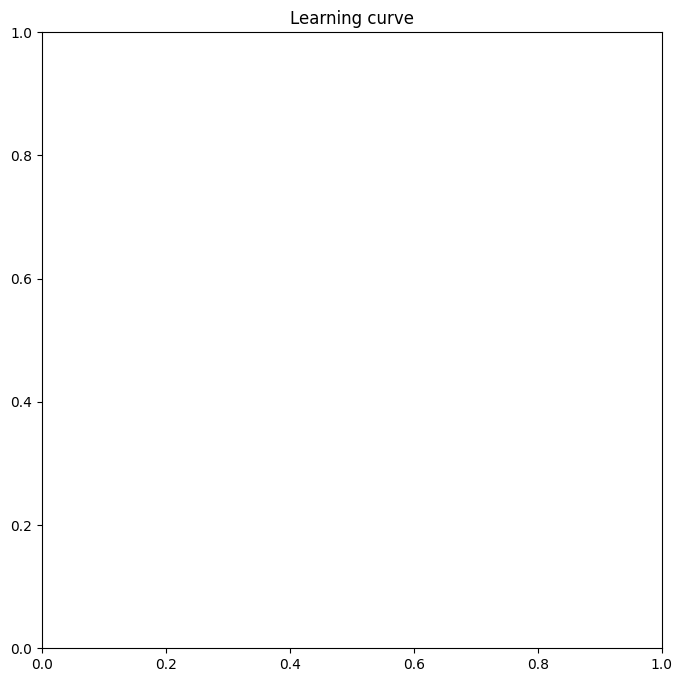

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["loss"], label="training loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.plot( np.argmin(history.history["val_loss"]), np.min(history.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("value (log scale)")
plt.legend()

**Precision plot**

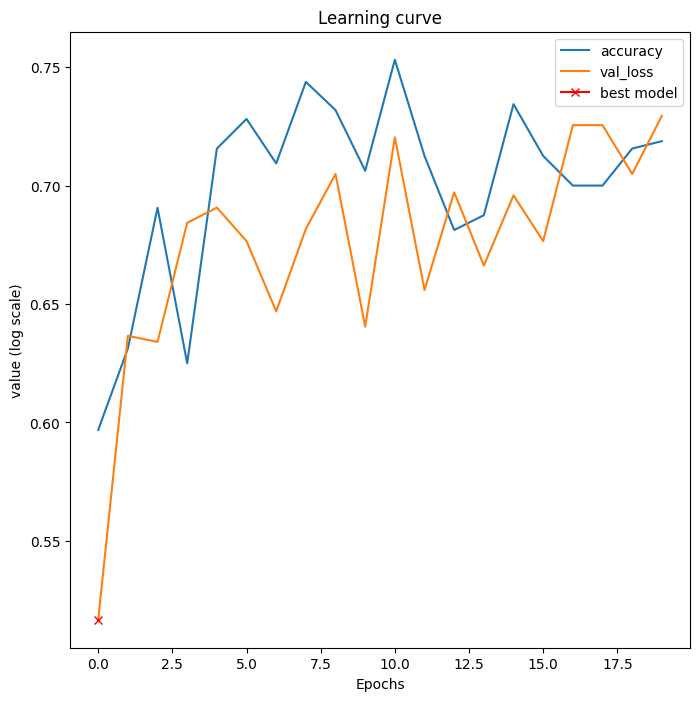

In [ ]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(history.history["precision"], label="accuracy")
plt.plot(history.history["val_precision"], label="val_loss")
plt.plot( np.argmin(history.history["val_precision"]), np.min(history.history["val_precision"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("value (log scale)")
plt.legend();

**Recall plot**

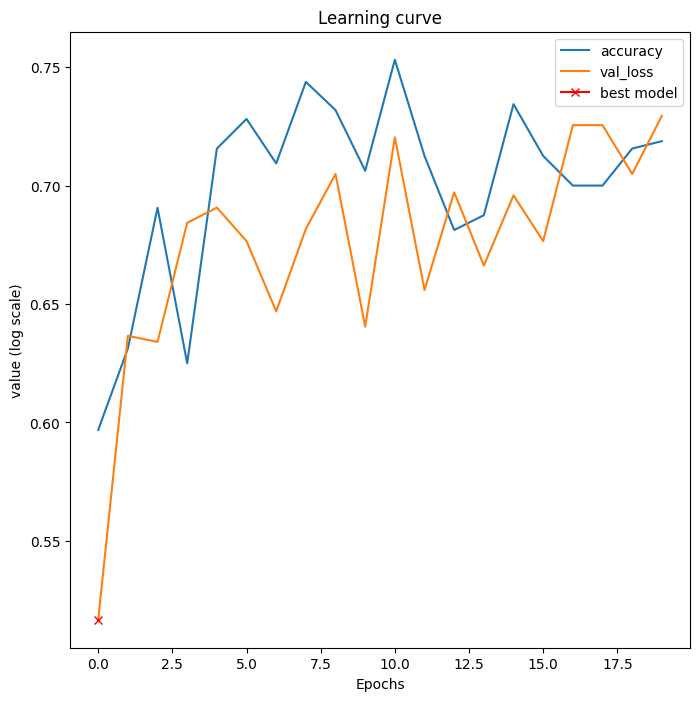

In [ ]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(history.history["precision"], label="accuracy")
plt.plot(history.history["val_precision"], label="val_loss")
plt.plot( np.argmin(history.history["val_precision"]), np.min(history.history["val_precision"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("value (log scale)")
plt.legend();

**AUC plot**

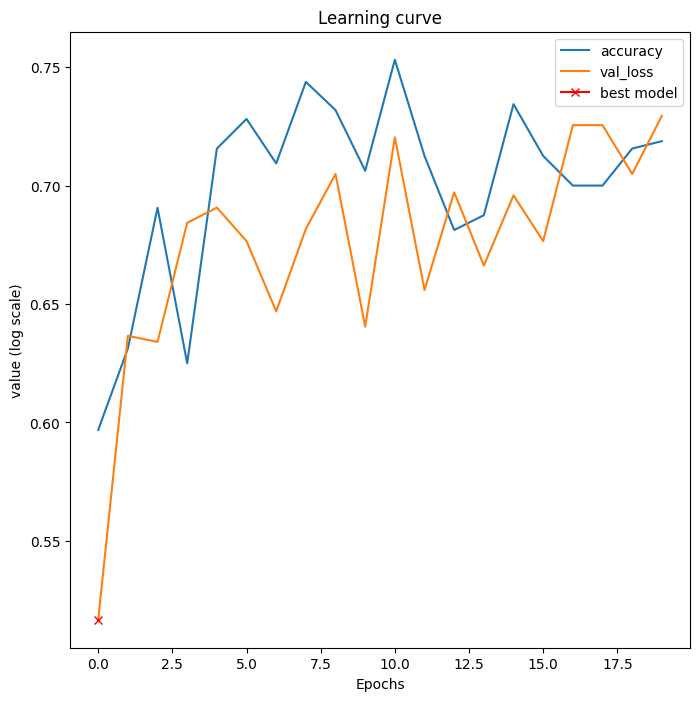

In [ ]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(history.history["precision"], label="accuracy")
plt.plot(history.history["val_precision"], label="val_loss")
plt.plot( np.argmin(history.history["val_precision"]), np.min(history.history["val_precision"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("value (log scale)")
plt.legend();

# Model prediction


In [ ]:
from keras.preprocessing import image
img = image.load_img('../input/curated-colon-dataset-for-deep-learning/test/0_normal/test_normal_ (1).jpg',target_size=(224,224))
imag = image.img_to_array(img)
imaga = np.expand_dims(imag,axis=0)
ypred = model.predict(imaga)
print(ypred)
a=np.argmax(ypred,-1)
if a==0:
    op="malignancy"
elif a==1:
    op="Benign"


plt.imshow(img)
print("THE UPLOADED IMAGE SEEMS TO BE: "+str(op))


In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/MT_project/my_model240719.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/MT_project/my_model.keras')

In [ ]:
from tensorflow.keras.models import load_model

loaded_model = load_model('my_model.keras')